In [60]:
import sys
sys.path.insert(0, "D:\\Documents\\food_recipe_gen\\recipe_1m_analysis")
import os
import pandas as pd
import torch
import utils
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
import csv

from sklearn import metrics
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Data preprocessing

In [49]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILES = ["random","cluster_centroid","full"]
dataset = DATASET[1]
file = FILES[2]

balanced = False
load = False

In [50]:
# TODO put together both datasets (same method of undersampling, or undersample afterwards ?) & test
df=pd.read_pickle(os.path.join(FOLDER_PATH,dataset,file+"_data.pkl"))
df=df.reset_index()
df

,index,id,cuisine,ingredients,all_ingredients
0,0,0,Italian,"[baby_bella_mushroom_sliced, arborio_rice, oli...",baby_bella_mushroom_sliced;arborio_rice;olive_...
1,2,2,Italian,"[garlic, extra-virgin_olive_oil_divided, madei...",garlic;extra-virgin_olive_oil_divided;madeira_...
2,3,3,French,"[garlic_halved, cooking_spray, peeled_red_pota...",garlic_halved;cooking_spray;peeled_red_potato_...
3,5,5,American,"[turkey_thawed, maple_syrup, bourbon, pickling...",turkey_thawed;maple_syrup;bourbon;pickling_spi...
4,6,6,American,"[beef_tenderloin__silver_skin_trimmed, worcest...",beef_tenderloin__silver_skin_trimmed;worcester...
...,...,...,...,...,...
26321,27633,27633,Italian,"[zwiebeln, knoblauchzehen, dose__dicke_weisse_...",zwiebeln;knoblauchzehen;dose__dicke_weisse_boh...
26322,27634,27634,American,"[fresh_lavender_blossom_, sugar, carrot_juice,...",fresh_lavender_blossom_;sugar;carrot_juice;pot...
26323,27635,27635,French,"[gr._bread_flour, ml._water, gr._yeast, gr._st...",gr._bread_flour;ml._water;gr._yeast;gr._strong...
26324,27636,27636,American,"[flour, unsweetened_cocoa_powder, baking_soda,...",flour;unsweetened_cocoa_powder;baking_soda;sal...


In [18]:
# df.loc[26321,"ingredients"] # written in german, could clean that

In [19]:
vocab_ingrs = utils.Vocabulary()
for ingredients in df.loc[:,"ingredients"]:
    for ingr in ingredients:
        vocab_ingrs.add_word(ingr)
vocab_ingrs.add_word("<unk>")
vocab_ingrs.word2idx

{'baby_bella_mushroom_sliced': 0,
 'arborio_rice': 1,
 'olive_oil': 2,
 'butter': 3,
 'shallot_minced': 4,
 'white_wine': 5,
 'fat_free_chicken_stock_': 6,
 'salt_pepper': 7,
 'grated_parmesan_cheese': 8,
 'chopped_parsley': 9,
 'garlic': 10,
 'extra-virgin_olive_oil_divided': 11,
 'madeira_divided': 12,
 'unsalted_chicken_stock_divided': 13,
 'dried_porcini_mushroom_': 14,
 'chopped_onion': 15,
 'thinly_sliced_cremini_mushroom_': 16,
 'thinly_sliced_shiitake_mushroom_cap_': 17,
 'uncooked_arborio_rice': 18,
 'parmesan_cheese_grated_': 19,
 'kosher_salt': 20,
 'freshly_ground_black_pepper': 21,
 'chopped_fresh_sage': 22,
 'sage_': 23,
 'garlic_halved': 24,
 'cooking_spray': 25,
 'peeled_red_potato_': 26,
 'butter_melted': 27,
 'salt': 28,
 'black_pepper': 29,
 'shredded_gruyere_cheese': 30,
 'fat-free_milk': 31,
 'turkey_thawed': 32,
 'maple_syrup': 33,
 'bourbon': 34,
 'pickling_spice': 35,
 'large_carrot_scraped': 36,
 'celery_rib': 37,
 'medium_onion_peeled_halved': 38,
 'lemon': 39

In [20]:
vocab_cuisine = utils.Vocabulary()
for cuisine in df['cuisine'].value_counts().index:
    vocab_cuisine.add_word(cuisine)
vocab_cuisine.word2idx

{'American': 0,
 'Italian': 1,
 'Mexican': 2,
 'Asian': 3,
 'French': 4,
 'Indian': 5,
 'Mediterranean': 6,
 'Spanish_Portuguese': 7,
 'Cuban': 8,
 'English_Irish': 9,
 'Moroccan': 10}

## Data processing

In [21]:
def ingr2idx(ingr_list):
    # If I didn't do the one-hot encoding by myself and used directly an embedding layer in the net, 
    # I would have to pad the input
    input_=[]
    for ingr in ingr_list:
        try:
            input_.append(vocab_ingrs.word2idx[ingr])
        except KeyError:
            input_.append(vocab_ingrs.word2idx["<unk>"])
    input_ = torch.LongTensor(input_)
    onehot_enc = F.one_hot(input_.to(torch.int64), INPUT_SIZE)
    output = torch.sum(onehot_enc,0)
    return output

class RecipesDataset(Dataset):
    """Recipes dataset for cuisine classification. Only from ingredients for now"""

    def __init__(self, input_,labels):
        """
        Args:
            file (string): Path to the file
        """
        self.input_ = input_
        self.labels = labels

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        # XXX useful ?
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ingr_one_hot = ingr2idx(self.input_.loc[idx,"ingredients"])
        label = vocab_cuisine.word2idx[self.labels.loc[idx,"cuisine"]]
        return ingr_one_hot, label
        

In [22]:
def make_weights_for_balanced_classes(samples, nclasses): 
    count = [0] * nclasses
    weight_per_class = [0.] * nclasses
    N = len(samples)
    
    for a,el in samples.value_counts().items():
        count[vocab_cuisine.word2idx[a]]=el

    for i in range(nclasses): # XXX to still sample the others, add log ? so goes back to N, not max(count)
        weight_per_class[i] = math.log(N/float(count[i])) # divide by max count[i] ? Or just different scale, order is same
        print(vocab_cuisine.idx2word[i], weight_per_class[i])
    weight = [0] * N
    
    for idx, val in enumerate(samples): 
        weight[idx] = weight_per_class[vocab_cuisine.word2idx[val]] 
        
    
    return torch.Tensor(weight_per_class), torch.DoubleTensor(weight)

# from https://gist.github.com/srikarplus/15d7263ae2c82e82fe194fc94321f34e

In [23]:
INPUT_SIZE = len(vocab_ingrs)
EMBED_DIM1 = 300
EMBED_DIM2 = 64
NUM_CLASSES = len(vocab_cuisine) #51 or 20
BATCH_SIZE = 100
PRINT_FREQ = 20
NB_EPOCHS = 30

Weighted random sampling, with stratified split for the train and test dataset. But loss doesn't decrease (need to see more epochs ?)

In [24]:
#TODO when switch to python file, can put num_workers & have to put if __name__ == '__main__':
X_train, X_dev, y_train, y_dev = train_test_split(df["ingredients"],df["cuisine"], test_size=0.1, random_state=42,stratify=df["cuisine"])

X_train = X_train.reset_index()
X_dev = X_dev.reset_index()
y_train = y_train.reset_index()
y_dev = y_dev.reset_index()

train_dataset = RecipesDataset(X_train,y_train)
dev_dataset = RecipesDataset(X_dev,y_dev)

if balanced:
    weights_classes, weights_labels = make_weights_for_balanced_classes(y_train["cuisine"], len(vocab_cuisine.word2idx)) 
    print(len(weights_labels))
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_labels, len(weights_labels)) 
    train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE, sampler = sampler)#, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE)#, pin_memory=True)    

dev_loader = DataLoader(dev_dataset,batch_size = 1)

# Model

In [26]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim1, embedding_dim2, num_classes):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(vocab_size, embedding_dim1, bias=True)
        self.layer_2 = nn.Linear(embedding_dim1, embedding_dim1, bias=True)
#         self.layer_3 = nn.Linear(embedding_dim1, embedding_dim2, bias=True)
        self.output_layer = nn.Linear(embedding_dim1, num_classes, bias=True)

    def forward(self, x):
        out = F.relu(self.layer_1(x))
        out = F.relu(self.layer_2(out))
#         out = F.relu(self.layer_3(out))
        out = self.output_layer(out)
        return out

net = Net(INPUT_SIZE, EMBED_DIM1, EMBED_DIM2, NUM_CLASSES)

## Training

In [27]:
if balanced:
    criterion = nn.CrossEntropyLoss(weights_classes)
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #change to Adam ?

In [28]:
if load:
    net.load_state_dict(torch.load(os.path.join(FOLDER_PATH,DATASET[1],"model_logweights")))
else:
    epoch_accuracy = []

    for epoch in range(NB_EPOCHS):

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0]
            labels = data[1]
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            if i % PRINT_FREQ == PRINT_FREQ-1:    # print every 2000 mini-batches
                print(f'[Epoch {epoch + 1}, Iteration {i + 1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

            accuracy = 100 * correct / total
        epoch_accuracy.append(accuracy)

        print(f'Accuracy of the network on epoch {epoch+1}: {accuracy:.3f}')

    print('Finished Training')

[Epoch 1, Iteration 20] loss: 0.023
[Epoch 1, Iteration 40] loss: 0.020
[Epoch 1, Iteration 60] loss: 0.017
[Epoch 1, Iteration 80] loss: 0.017
[Epoch 1, Iteration 100] loss: 0.016
[Epoch 1, Iteration 120] loss: 0.016
[Epoch 1, Iteration 140] loss: 0.016
[Epoch 1, Iteration 160] loss: 0.016
[Epoch 1, Iteration 180] loss: 0.016
[Epoch 1, Iteration 200] loss: 0.016
[Epoch 1, Iteration 220] loss: 0.015
Accuracy of the network on epoch 1: 45.195
[Epoch 2, Iteration 20] loss: 0.015
[Epoch 2, Iteration 40] loss: 0.015
[Epoch 2, Iteration 60] loss: 0.014
[Epoch 2, Iteration 80] loss: 0.014
[Epoch 2, Iteration 100] loss: 0.014
[Epoch 2, Iteration 120] loss: 0.013
[Epoch 2, Iteration 140] loss: 0.013
[Epoch 2, Iteration 160] loss: 0.012
[Epoch 2, Iteration 180] loss: 0.012
[Epoch 2, Iteration 200] loss: 0.011
[Epoch 2, Iteration 220] loss: 0.011
Accuracy of the network on epoch 2: 55.261
[Epoch 3, Iteration 20] loss: 0.010
[Epoch 3, Iteration 40] loss: 0.009
[Epoch 3, Iteration 60] loss: 0.009


[Epoch 19, Iteration 40] loss: 0.001
[Epoch 19, Iteration 60] loss: 0.001
[Epoch 19, Iteration 80] loss: 0.001
[Epoch 19, Iteration 100] loss: 0.001
[Epoch 19, Iteration 120] loss: 0.000
[Epoch 19, Iteration 140] loss: 0.001
[Epoch 19, Iteration 160] loss: 0.001
[Epoch 19, Iteration 180] loss: 0.001
[Epoch 19, Iteration 200] loss: 0.001
[Epoch 19, Iteration 220] loss: 0.001
Accuracy of the network on epoch 19: 97.776
[Epoch 20, Iteration 20] loss: 0.000
[Epoch 20, Iteration 40] loss: 0.001
[Epoch 20, Iteration 60] loss: 0.001
[Epoch 20, Iteration 80] loss: 0.001
[Epoch 20, Iteration 100] loss: 0.001
[Epoch 20, Iteration 120] loss: 0.000
[Epoch 20, Iteration 140] loss: 0.000
[Epoch 20, Iteration 160] loss: 0.000
[Epoch 20, Iteration 180] loss: 0.000
[Epoch 20, Iteration 200] loss: 0.000
[Epoch 20, Iteration 220] loss: 0.000
Accuracy of the network on epoch 20: 98.886
[Epoch 21, Iteration 20] loss: 0.000
[Epoch 21, Iteration 40] loss: 0.000
[Epoch 21, Iteration 60] loss: 0.000
[Epoch 21,

In [52]:
date = datetime.now().strftime("%m-%d-%H-%M")
RESULTS_FOLDER = os.path.join(FOLDER_PATH,dataset,f"results_{date}{balanced*'_bal'}_{file}")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


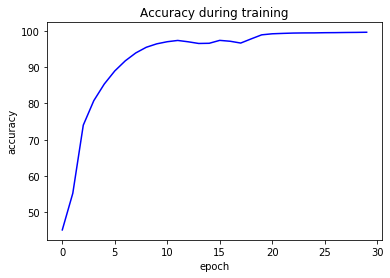

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
x_points = [i for i in range(0,NB_EPOCHS)]
# epoch_accuracy2=[]
# for i in range(len(epoch_accuracy)):
#     if i%237==0:
#         epoch_accuracy2.append(epoch_accuracy[i])
p = ax.plot(x_points, epoch_accuracy, 'b')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy during training')
fig.show()

fig.savefig(os.path.join(RESULTS_FOLDER,'accuracy_training.png'), dpi=fig.dpi)

## Testing on dev set

In [54]:
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [59]:
def score(network, dataloader,test=False,threshold=None):
    count_unk=0
    correct = 0
    total = 0
    all_predict = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0]

            # Removing samples where you don't know more than 2 of the ingr doesn't help the model much
            if inputs[0][vocab_ingrs.word2idx["<unk>"]]>3:
                count_unk+=1
                continue

            labels = data[1]
            outputs = network(inputs.float())
            
            if test:
                # Only taking the prediction when the model thinks it's threshold% probable that the label is x
                # Also not that good, accuracy of 42% instead of 82% on dev set 
                proba = torch.nn.functional.softmax(outputs,dim=1)
                p_max, predicted = torch.max(proba,1)
                if p_max < threshold:
                    continue
            else:
                _, predicted = torch.max(outputs.data, 1)
            
            all_predict.append(predicted)
            all_labels.append(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print(f'Accuracy of the network on the dataset: {accuracy:.3f}% for {total} samples')

    one_hot_pred = F.one_hot(torch.LongTensor(all_predict).to(torch.int64), NUM_CLASSES)
    one_hot_lab = F.one_hot(torch.LongTensor(all_labels).to(torch.int64), NUM_CLASSES)
    fbeta_pytorch = f2_score(one_hot_pred, one_hot_lab)

    print(f'Score is {100* fbeta_pytorch:.3f}%')
    print(f'Count unknown ingr: {count_unk}')
    
    return accuracy, fbeta_pytorch

dev_accuracy, dev_fscore = score(net,dev_loader)

Accuracy of the network on the dataset: 83.593% for 2633 samples
Score is 83.593%
Count unknown ingr: 0


## On test set

In [56]:
df_test=pd.read_pickle(os.path.join(FOLDER_PATH,DATASET[0],FILES[1]+"_data.pkl"))
df_test = df_test[df_test["cuisine"].isin(vocab_cuisine.word2idx.keys())] #some labels not existing in train dataset
df_test_s=df_test.sample(5000)
df_test_s=df_test_s.reset_index()

test_dataset=RecipesDataset(pd.DataFrame(df_test_s["ingredients"]),pd.DataFrame(df_test_s["cuisine"]))

test_loader = DataLoader(test_dataset, batch_size=1)#, sampler = sampler)

In [73]:
threshold = 0.90
test_accuracy, test_fscore = score(net,test_loader,test=True,threshold=threshold)

Accuracy of the network on the dataset: 62.946% for 3001 samples
Score is 62.946%
Count unknown ingr: 31


In [58]:
torch.save(net.state_dict(), os.path.join(RESULTS_FOLDER,"model_logweights"))

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(RESULTS_FOLDER,"training_state_logweights"))

In [72]:
results_file = os.path.join(FOLDER_PATH,dataset,"results.csv")
if os.path.isfile(results_file):
    with open(results_file,"w", newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow(["date","file","balanced","epoch","train_accuracy","dev_accuracy","dev_fscore","test_accuracy","test_fscore","threshold"])
        writer.writerow([date,file,balanced,NB_EPOCHS,epoch_accuracy[-1],dev_accuracy,dev_fscore,test_accuracy,test_fscore,threshold])
else:
    with open(results_file,"a", newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow([date,file,balanced,NB_EPOCHS,epoch_accuracy[-1],dev_accuracy,dev_fscore,test_accuracy,test_fscore,threshold])